# Object Detection - Part 5 Final
by John Robinson 03/21/2023 [Follow @johnrobinsn on Twitter](https://twitter.com/johnrobinsn)

[<img src="https://www.storminthecastle.com/img/github.svg">](https://github.com/johnrobinsn/ObjectDetectionNotebooks/blob/main/nbs/05_ssd_final.ipynb) [<img src="https://www.storminthecastle.com/img/colab.svg">](https://colab.research.google.com/github/johnrobinsn/ObjectDetectionNotebooks/blob/main/nbs/05_ssd_final.ipynb)

This is **Part 5 and the final article in my series** on building an intuition for how single-pass oject detectors such as YOLO and SSD work.  We've covered a lot of ground over the last four articles and in this article we're just adding some final touches.  If you haven't read the previous articles in the series, I recommend that you do so before continuing. [Go Back to Part 1.](https://www.storminthecastle.com/posts/01_classification/)  

Here is my final trained model in action. I'm pretty happy with how it turned out. I'll show you how to replicate the results using my trained weights later in this article. But before that I'm going to walk you through the details and show you how you could train this model yourself and share some thoughts on how you might be able to even make it even better. [Click here](https://drive.google.com/uc?id=1PoS0PFHX07-jeLLYGNFUwdilC9nh6nOK) to see the video full screen.

<video src="https://drive.google.com/uc?id=1PoS0PFHX07-jeLLYGNFUwdilC9nh6nOK" autoplay loop width=800 controls></video>

_Note: Credit for the video goes to NTR & Ram Charon on [Youtube](https://www.youtube.com/watch?v=--rAA0lXNfQ). If you want to learn the Naatu Naatu dance from the RRR movie, they're the ones to learn it from..._

Object detection considers the problem of building a model that can take an image and can detect multiple objects within that image; predicting not only the object classes but also the bounding boxes of those objects within the image.  Single-pass detectors such as YOLO and SSD are able to perform this object detection task in a single forward inference pass of the model. 

In the last article, I showed you how to add support for detecting multiple objects simultaneously and in this article we're going to scale that approach up a lot so that it can detect many more objects and can detect objects at different scales and aspect ratios.  To do this, we'll be increasing the number of anchor boxes and associated object detectors from the sixteen that we had last time.  I also wanted to scale up the amount of data that we had to train on as well.

The FastAI subset of the COCO 2017 dataset was extremely useful in the earlier phases of the project when I was iterating and debugging a lot, but now that things are working pretty smoothly I decided to switch to the full COCO 2017 dataset.  We'll leverage the torchvision module since it has good support for parsing the COCO annotations from the full dataset making this switch fairly straightforward. The upside of this is that we can detect a much wider variety of objects.  The downside is that the dataset is much larger and the training time is much longer.  I'll finish up by showing how to use my trained model to detect objects in your own images. I'll also show you how to use the model to detect objects in a video stream.

We'll start by installing the necessary dependencies.

In [1]:
def install_dependencies():
    !pip install -Uqq fastai
    !pip install -Uqq git+https://github.com/johnrobinsn/course22p2.git  # installing from my fork to try and keep this notebook working.  Please see upstream for latest!
    !pip install -Uqq git+https://github.com/johnrobinsn/imgaug.git
    !pip install -Uqq pycocotools
    !pip install -Uqq gdown  # install gdown to download files from google drive

install_dependencies()

Importing the necessary libraries.

In [2]:
import sys
from pathlib import Path

from miniai.activations import set_seed
from miniai.datasets import show_image
from miniai.learner import *

from fastai.vision.all import L,imagenet_stats,create_body,resnet34

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import HTML
import cv2

import torch
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
#from torch.utils.data.dataloader import default_collate
import torch.nn.functional as F

from torchvision import transforms as tfms
from torchvision.datasets import CocoDetection

from imgaug.augmentables.bbs import BoundingBoxesOnImage
from imgaug import augmenters as iaa 

IN_COLAB = 'google.colab' in sys.modules

device = torch.device('cuda',0) if torch.cuda.is_available() else torch.device('cpu')
set_seed(6789, deterministic=False)

SIZE = 224  # size of images we'll use for the model


## Interested in Inference Only
Are you interested in just trying out inference using my pretrained model rather than training the model yourself. If so change the following `INFERENCE_ONLY` variable to `True` and the code in the notebook will skip the data download, training etc.

Colab seems to have a very slow link when downloading from the COCO site (to be fair the dataset is large) and training the model takes a long time (> 24 hours) so trying to train fully on CoLab is pretty painful.  If you do want to train the model yourself, I'd suggest using your own machine with GPU or a cloud GPU provider that provides good persistent storage and an unlimited session time.  For this reason, I configure INFERENCE_ONLY to True if you're running on CoLab.  

_Note: Explicitly change the value of INFERENCE_ONLY based on your environment and your desired objective._

In [3]:
INFERENCE_ONLY = True if IN_COLAB else False

Here we'll download the [COCO 2017 dataset](https://cocodataset.org/#home) and extract it to the specified location.  This will take a few minutes.  The dataset is about 21GB in size.

In [4]:
data_path = "./coco_2017" # Path to where you want to store the data

def download_coco():
    print('Coco Download Started.')
    !mkdir -p {data_path}
    !curl "http://images.cocodataset.org/annotations/annotations_trainval2017.zip" > {data_path}/annotations_trainval2017.zip
    !unzip -q -o {data_path}/annotations_trainval2017.zip -d {data_path}
    !rm {data_path}/annotations_trainval2017.zip
    !curl "http://images.cocodataset.org/zips/val2017.zip" > {data_path}/val2017.zip
    !unzip -q -o {data_path}/val2017.zip -d {data_path}
    !rm {data_path}/val2017.zip
    if not INFERENCE_ONLY:
        !curl "http://images.cocodataset.org/zips/train2017.zip" > {data_path}/train2017.zip
        !unzip -q -o {data_path}/train2017.zip -d {data_path}
        !rm {data_path}/train2017.zip
    else: print('Warning: Inference Only Skipping download of training dataset')
    print('Coco Download Completed.')

download_coco()


Coco Download Started.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  241M  100  241M    0     0  72.3M      0  0:00:03  0:00:03 --:--:-- 72.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  777M  100  777M    0     0  92.6M      0  0:00:08  0:00:08 --:--:-- 95.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.0G  100 18.0G    0     0  45.4M      0  0:06:45  0:06:45 --:--:-- 46.8M      0  0:06:48  0:00:35  0:06:13 30.2M 0     0  49.8M      0  0:06:09  0:01:02  0:05:07 57.6M      0  0:07:22  0:02:50  0:04:32 52.3M3.6M      0  0:07:02  0:03:36  0:03:26 51.7M0  46.2M      0  0:06:38  0:04:48  0:01:50 61.2M
Coco Download Completed.


Similar to what we did the last time, we'll statically define the set of object classes in our dataset but now that we're using the full thing we'll have 80 classes (plus background) to work with.  We'll also create dictionaries to map back-and-forth between class string labels and class indices and define a set of colors (one for each class and then some) so that we have consistent coloring for each class when we draw our object annotations.

In [5]:
colors = [None, (39, 129, 113), (164, 80, 133), (83, 122, 114), (99, 81, 172), (95, 56, 104), (37, 84, 86),
          (14, 89, 122),
          (80, 7, 65), (10, 102, 25), (90, 185, 109), (106, 110, 132), (169, 158, 85), (188, 185, 26), (103, 1, 17),
          (82, 144, 81), (92, 7, 184), (49, 81, 155), (179, 177, 69), (93, 187, 158), (13, 39, 73), (12, 50, 60),
          (16, 179, 33), (112, 69, 165), (15, 139, 63), (33, 191, 159), (182, 173, 32), (34, 113, 133), (90, 135, 34),
          (53, 34, 86), (141, 35, 190), (6, 171, 8), (118, 76, 112), (89, 60, 55), (15, 54, 88), (112, 75, 181),
          (42, 147, 38), (138, 52, 63), (128, 65, 149), (106, 103, 24), (168, 33, 45), (28, 136, 135), (86, 91, 108),
          (52, 11, 76), (142, 6, 189), (57, 81, 168), (55, 19, 148), (182, 101, 89), (44, 65, 179), (1, 33, 26),
          (122, 164, 26), (70, 63, 134), (137, 106, 82), (120, 118, 52), (129, 74, 42), (182, 147, 112), (22, 157, 50),
          (56, 50, 20), (2, 22, 177), (156, 100, 106), (21, 35, 42), (13, 8, 121), (142, 92, 28), (45, 118, 33),
          (105, 118, 30), (7, 185, 124), (46, 34, 146), (105, 184, 169), (22, 18, 5), (147, 71, 73), (181, 64, 91),
          (31, 39, 184), (164, 179, 33), (96, 50, 18), (95, 15, 106), (113, 68, 54), (136, 116, 112), (119, 139, 130),
          (31, 139, 34), (66, 6, 127), (62, 39, 2), (49, 99, 180), (49, 119, 155), (153, 50, 183), (125, 38, 3),
          (129, 87, 143), (49, 87, 40), (128, 62, 120), (73, 85, 148), (28, 144, 118), (29, 9, 24), (175, 45, 108),
          (81, 175, 64), (178, 19, 157), (74, 188, 190), (18, 114, 2), (62, 128, 96), (21, 3, 150), (0, 6, 95),
          (2, 20, 184), (122, 37, 185)]

vocab = ["bg", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
                "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog",
                "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
                "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite",
                "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
                "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange",
                "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant",
                "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone",
                "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
                "teddy bear", "hair drier", "toothbrush"]

cat2id = {v:k for k,v in enumerate(vocab)}
id2cat = {k:v for k,v in enumerate(vocab)}

print(f'The number of classes in the dataset: {len(vocab)}')

The number of classes in the dataset: 81


The torchvision library provides a CocoDetection dataset class that we subclass to provide the necessary functionality to parse the COCO annotations and return the images and bounding boxes in the format that we need.  Our subclass will also support a transform operation that will be used to wrap our imgaug powered augmentions used during training (covered in earlier articles).  

I also moved the tensor padding for the bounding boxes and class tensors into a custom collate function shown below.  This is a little more efficient than doing it in the dataset class since the padding will happen batch by batch rather than assuming some maximum number of bounding boxes and classes for the entire dataset.

In [6]:
def pad_bb_tensor(t, m):
    return torch.cat([t, torch.zeros(m - len(t), 4)], dim=0)

def pad_cl_tensor(t, m):
    return torch.cat([t, torch.zeros(m - len(t))], dim=0).long()

# We need to zero-pad the boxes and labels to the max number of boxes in a batch
def collate_fn(batch):
    items = list(zip(*batch))
    
    m = 0
    for i in items[1]:
        if i is None:
            continue
        l = len(i) 
        if l > m: m = l

    items[0] = default_collate([i for i in items[0] if torch.is_tensor(i)])
    boxes = [pad_bb_tensor(i,m) for i in items[1] if torch.is_tensor(i)]
    clses = [pad_cl_tensor(i,m) for i in items[2] if torch.is_tensor(i)]

    items[1] = default_collate(boxes)
    items[2] = default_collate(clses)

    return items

class CocoDataset(CocoDetection):
    def __init__(self, root, year, mode, transform=None):
        root = Path(root)
        annFile = root/f"annotations/instances_{mode}{year}.json"
        root = root/f"{mode}{year}"
        super(CocoDataset, self).__init__(root, annFile)
        self._load_categories()
        self.transform = transform

    def _load_categories(self):
        categories = self.coco.loadCats(self.coco.getCatIds())
        categories.sort(key=lambda x: x["id"])

        self.label_map = {}
        self.label_info = {}
        counter = 1
        self.label_info[0] = "background"
        for c in categories:
            self.label_map[c["id"]] = counter
            self.label_info[counter] = c["name"]
            counter += 1

    def __getitem__(self, item):
        image, target = super(CocoDataset, self).__getitem__(item)
        width, height = image.size
        boxes = []
        labels = []
        if len(target) == 0:
            return None, None, None, None, None
        for annotation in target:
            bbox = annotation.get("bbox")
            boxes.append([bbox[0], bbox[1], (bbox[0] + bbox[2]), (bbox[1] + bbox[3])])
            labels.append(self.label_map[annotation.get("category_id")])
        if self.transform is not None:
            image, (height, width), boxes, labels = self.transform(image, (height, width), boxes, labels)
        return image, torch.tensor(boxes), torch.tensor(labels).long()


The Xfm class wraps our imgaug powered image augmentations used during training.

In [7]:
# RGB channel means and standard deviations for the ImageNet dataset
xmean,xstd = L(imagenet_stats).map(tensor)

# denormalize the image data based on imagenet stats
def denormalize(x):
    return x*xstd[...,None,None]+xmean[...,None,None]

# scale and center the image data based on imagenet stats
def normalize(x):
    return (x-xmean[:,None,None])/xstd[:,None,None]
    
class Xfm(object):
    def __init__(self,size,augment=True):
        self.augment = augment
        self.size = size
        self.tseq = iaa.Sequential([
            iaa.Scale({"height": size[0], "width": size[1]}),
            iaa.Fliplr(0.5),
            iaa.Flipud(0.20),
            iaa.GammaContrast(1.5),
            iaa.Sometimes(
                0.5,iaa.Sequential([iaa.Affine(translate_percent={"x": (-0.15,0.15),"y": (-0.15,0.15)},rotate=(5,-5), scale=(0.15, 1.5)),
                iaa.CoarseDropout(0.1, per_channel=True)    
            ]))
        ])
        self.vseq = iaa.Sequential([
            iaa.Scale({"height": size[0], "width": size[1]})
        ])

    def __call__(self,img,_img_size,bboxes=None,labels=None):
        img = np.array(img)
        bbs = BoundingBoxesOnImage.from_xyxy_array(bboxes, shape=img.shape)
        if (self.augment): 
            n = len(list(bbs.bounding_boxes))

            im_aug,bbs_aug = self.tseq(image=img, bounding_boxes=bbs)
            bbs_aug = bbs_aug.clip_out_of_image()
            n2 = len(list(bbs_aug.bounding_boxes))         
            if n != n2: # at least one bounding box is fully outside of the image boundary
                # bail out of augmentation for this sample
                #print('bailing out of augmentation for this sample')
                im_aug,bbs_aug = self.vseq(image=img, bounding_boxes=bbs)
        else: im_aug,bbs_aug = self.vseq(image=img, bounding_boxes=bbs)

        b = (bbs_aug.to_xyxy_array()/(self.size[0]/2))-1  # scale the bounding boxes to be between -1 and 1

        img = normalize(tfms.ToTensor()(im_aug)) # normalize the image data with imagenet stats

        return img,self.size,b,labels

Define our training and validation datasets and dataloaders.

In [8]:
num_workers = 2 if IN_COLAB else 6 # not much memory on CoLab so use less workers
batch_size = 32
num_gpus = 1

train_params = {"batch_size": batch_size * num_gpus,
                "shuffle": True,
                "drop_last": False,
                "num_workers": num_workers,
                "collate_fn": collate_fn
                }

valid_params = {"batch_size": batch_size * num_gpus,
                "shuffle": False,
                "drop_last": False,
                "num_workers": num_workers,
                "collate_fn": collate_fn
                }


valid_set = CocoDataset(data_path, 2017,"val",Xfm((SIZE,SIZE),False))
valid_loader = DataLoader(valid_set,**valid_params)

if not INFERENCE_ONLY:
    train_set = CocoDataset(data_path,2017,"train",Xfm((SIZE,SIZE),True))
    train_loader = DataLoader(train_set,**train_params)

    dls = DataLoaders(train_loader,valid_loader)

/home/jr/anaconda3/envs/fastaip2_4/lib/python3.9/site-packages/imgaug/imgaug.py:188: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  warn_deprecated(msg, stacklevel=3)


loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
loading annotations into memory...
Done (t=12.85s)
creating index...
index created!


## Visualize the dataset
Now that we have our dataset and dataloaders defined, we can visualize the dataset to make sure everything is working as expected.  We'll define a new `showobjects` function to display an image along with it's ground truth bounding boxes and class labels.  The 'showobjects' function uses opencv to render the annotations and is much faster than the matplotlib based visualization functions that we used in the earlier articles.

In [9]:
# takes an image tensor; denormalizes it and scales it up so that we have enough pixels to render our annotations reasonably
def denormalize_tensor(im_tensor):
    im = denormalize(im_tensor)
    im = (im - im.min()/(im.max()-im.min())).clip(0,1)
    im = np.array(im.permute(1,2,0)*255).astype(np.uint8).copy()
    im = cv2.resize(im, (768,768))
    return im

def showobjects(im,bbox,clas):
    annotated_im = np.copy(im)

    # composite annotations onto image
    h,w = annotated_im.shape[:2]
    # for each non-background class label
    for i in range(len(clas)):
        if clas[i] == 0: continue # skip background
        category=id2cat[clas[i].item()]
        color = colors[clas[i]]

        box = (bbox[i]+1)/2
        x1,y1,x2,y2 = box.tolist()
        x1 = int(x1*w)
        x2 = int(x2*w)
        y1 = int(y1*h)
        y2 = int(y2*h)

        # draw bounding box
        cv2.rectangle(annotated_im,(x1,y1),(x2,y2),color,2)

        # draw category label
        text_size = cv2.getTextSize(category, cv2.FONT_HERSHEY_PLAIN, 1.5, 1)[0]
        cv2.rectangle(annotated_im, (x1, y1), (x1 + text_size[0] + 3, y1 + text_size[1] + 4), color,
                        -1)
        cv2.putText(annotated_im, category,
            (x1, y1 + text_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1.5,
            (255, 255, 255), 1)   
    return annotated_im

Show a few images from the validation dataset.

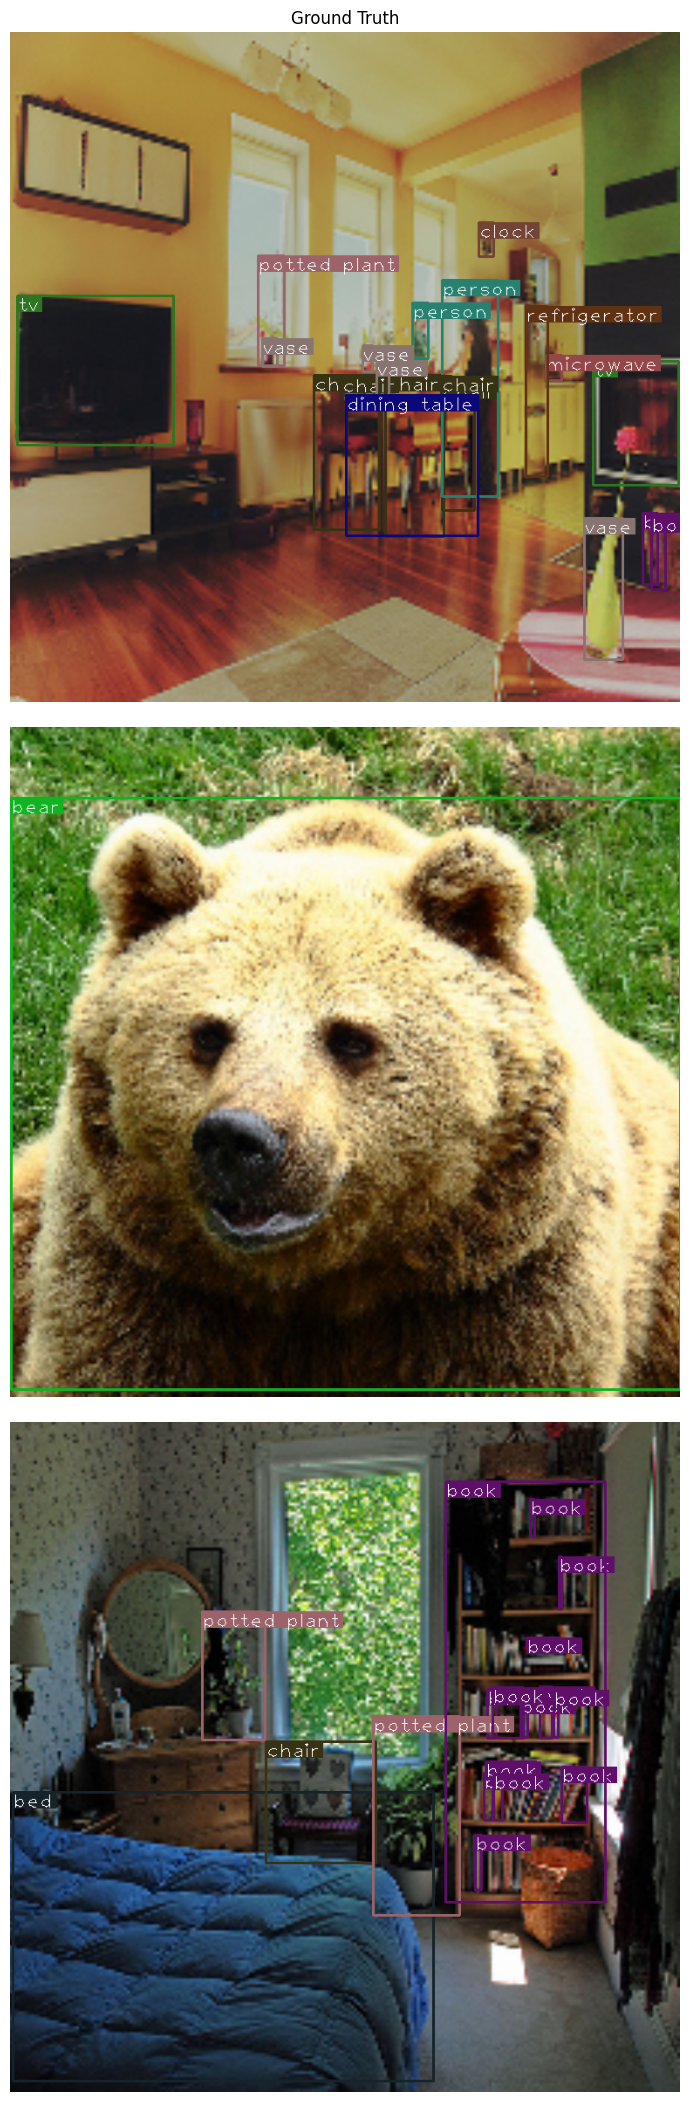

In [10]:
num_to_show = 3
fig,ax = plt.subplots(num_to_show,1,figsize=(7,7*num_to_show))
for i in range(num_to_show):
    show_image(showobjects(denormalize_tensor(valid_set[i][0]),valid_set[i][1],valid_set[i][2]),ax=ax[i])
fig.tight_layout()
_ = ax[0].set_title('Ground Truth')


### Define the anchor boxes
In the last article, we only created 16 anchor boxes and associated it with the single 4x4 feature map in our SSD Head. 

We're still sticking with the resnet34 body that we've been using up until now, but in our new head we'll be using the same stride two convolution technique to create even more more feature maps with ever increasing receptive fields. Rather than the single 4x4 feature map, our new head will have a 7x7 feature map, a 4x4 feature map, a 2x2 feature map and finally a 1x1 feature map.  We're also going to add a lot of additional anchor boxes and associate them with each of these feature maps in our new scaled-out SSD Head. For each feature map location in each feature map we'll be creating 45 anchor boxes of different offsets, and aspect ratios.  We'll also make sure that the anchor boxes overlap as they're tiled across the receptive fields of the feature maps to make sure that we have good overlapping coverage for matching the ground truth bounding boxes to our anchor boxes.  

When I define the model architecture for the head (covered a little further down in the article), I printed out the feature map sizes for the relevant layers.  I have included those details here for reference.

_Note: I left the print statements in the definition of the head (off by default) so that can easily enable them and see the feature map sizes for yourself._

Here are the feature maps that our new SSD Head will be using.

```
sconv0: torch.Size([32, 256, 7, 7])  # 7x7 feature map; 7x7x45 = 2205 (anchor boxes/object detectors)
out0: torch.Size([32, 2205, 4])      # 2205 anchor boxes with 4 activations each
sconv1: torch.Size([32, 256, 4, 4])  # 4x4 feature map; 4x4x45 = 720 (anchor boxes/object detectors)
out1: torch.Size([32, 720, 4])       # 720 anchor boxes with 4 activations each
sconv2: torch.Size([32, 256, 2, 2])  # 2x2 feature map; 2x2x45 = 180 (anchor boxes/object detectors)
out2: torch.Size([32, 180, 4])       # 180 anchor boxes with 4 activations each
sconv3: torch.Size([32, 256, 1, 1])  # 1x1 feature map; 1x1x45 = 45 (anchor boxes/object detectors)
out3: torch.Size([32, 45, 4])        # 45 anchor boxes with 4 activations each
```

This will give us 3,150 anchor boxes in all.
7x7x45 + 4x4x45 + 2x2x45 + 1x1x45 = 3,150

That's a lot of anchor boxes and for each one of these anchor boxes our model will need to support an object detector consisting of 4 activations for each bounding box and 81 activations for the class probabilities.  That's a lot of activations and a lot of parameters to train.

I should say that there is nothing magical about the number 45.  I just started laying out a pattern of anchor boxes that I wanted to use for each feature map location and then I just kept adding more and more until I was happy with the results.  I'm sure that there are better ways to do this, but this is what I came up with. Definitely something to experiment with if you want to try and improve the results.

_Note: Given the large number anchor boxes and the fact that they overlap, I found it very difficult to find a way to show it visually.  So you might want to write a little code to dump out the coorinates from the mk_unit_anchors function to try and get a feel for it._

In [11]:
# Function to convert BB format: (centers and dims) -> corners
def hw2corners(ctr,hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)
def corners2hw(xy1,xy2): return torch.cat([(xy1+xy2)/2, xy2-xy1], dim=1)

# Function to create a pattern of 45 overlapping anchor boxes in unit coordinates
# and allow for scaling and translation
def mk_unit_anchors(scale,x,y,half=True):
    a = []
    # xyxy format!!
    
    l3 = 1.0
    n3 = l3 * 0.33334
    s3 = -n3
    e3 = 1.+n3-l3

    l5 = 0.5
    n5 = l5 * 0.33334
    s5 = -n5
    e5 = 1.+n5-l5

    # will create 9 square anchor boxes tiled in an overlapping 3x3 grid
    xs = np.linspace(s3,e3,3)
    ys = np.linspace(s3,e3,3)
    a.extend([[y,x,y+l3,x+l3] for y in ys for x in xs])

    if half:
        # will create 18 rectangular boxes tiled in an overlapping 3x6 grid
        # aspect ratio is 1:0.5
        xs = np.linspace(s3,e3,3)
        ys = np.linspace(s5,e5,6)
        a.extend([[x,y,x+l3,y+l5] for y in ys for x in xs])

        # will create 18 rectangular boxes tiled in an overlapping 6x3 grid
        # aspect ratio is 0.5:1
        xs = np.linspace(s5,e5,6)
        ys = np.linspace(s3,e3,3)
        a.extend([[x,y,x+l5,y+l3] for y in ys for x in xs])

    return torch.clamp(tensor(a)*scale+tensor([x,y,x,y]),min=0,max=1)

Using the functions above, we'll create a set of anchor boxes for each feature map and for each feature map location.

In [12]:
# if image space is defined as 0.-1., then the following are the anchor box scales
# for each feature map layer
s7 = 0.125
s4 = 0.25
s2 = 0.5
s1 = 1.0

a7 = len(mk_unit_anchors(s7,0,0))
a4 = len(mk_unit_anchors(s4,0,0))
a2 = len(mk_unit_anchors(s2,0,0))
a1 = len(mk_unit_anchors(s1,0,0))

anchors_per_map_location = [a7,a4,a2,a1]

# for each feature map 'location' create a set of anchor boxes (45)
anchor_cnr = torch.cat([
    torch.cat([mk_unit_anchors(s7,i*s7,j*s7) for i in range(7) for j in range(7)]),     # for 7x7x45
    torch.cat([mk_unit_anchors(s4,i*s4,j*s4) for i in range(4) for j in range(4)]),     # for 4x4x45
    torch.cat([mk_unit_anchors(s2,i*s2,j*s2) for i in range(2) for j in range(2)]),     # for 2x2x45
    mk_unit_anchors(s1,0,0) # for 1x1x45
    ]).to(device)

anchors = corners2hw(anchor_cnr[:,:2], anchor_cnr[:,2:]).to(device)

print('The total number of anchor boxes is: ',len(anchors))

The total number of anchor boxes is:  3150


### The Model

As in earlier articles, we'll continue to use a resnet34 backbone with a custom head.  But as I mentioned earlier we're going to really blow out the number of feature map layers and the number of activations per feature map location.

Let's take a closer look at the resnet34 backbone by first cutting off it's existing head and running a batch of images (batch size 64) through it and examining the shape of it's output.


In [13]:
body = create_body(resnet34(True))

x,*_ = next(iter(valid_loader)) # get a batch of images from the training dataset
print('The shape of the batch of images is',x.shape)

/home/jr/anaconda3/envs/fastaip2_4/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/jr/anaconda3/envs/fastaip2_4/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The shape of the batch of images is torch.Size([32, 3, 224, 224])


In [14]:
print('The shape of the output activations for our resnet34 backbone is',body(x).shape) # pass the batch through the body of the model

The shape of the output activations for our resnet34 backbone is torch.Size([32, 512, 7, 7])


The output tensor of the backbone is 7x7 with 512 channels.  The new custom head with start with this 7x7 feature map and will add 3 more feature maps (using stride 2 convolutions) with increasingly larger receptive fields. The second feature map will be 4x4, the third will be 2x2 and the fourth will be 1x1.

In [15]:
class StdConv(nn.Module):
    def __init__(self,nin,nout,stride=2,drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin,nout,3,stride=stride,padding=1) 
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
    
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

# For each one of the object detectors we will need to have 21 activations for our class labels
# and 4 activations for the bounding box coordinates.
class OutConv(nn.Module):
    def __init__(self,k,nin,bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin,(len(vocab))*k,3,padding=1)
        self.oconv2 = nn.Conv2d(nin,4*k,3,padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x),self.k),
                flatten_conv(self.oconv2(x),self.k)]

The first feature map in the head will use the same feature map size as the backbone (7x7) we'll just do a stride 1 convolution to add some more compute.  Then using the stride two convolution approach from before we'll create a 4x4 feature map, then a 2x2 feature map and finally a 1x1 feature map. The parameters a7,a4,a2 and a1 define the number of object detectors (and anchor boxes) that we'll want for each feature map location in each respective feature map.

In [16]:
drop=0.0
class SSD_MultiHead(nn.Module):
    def __init__(self, bias=-4, printit=False):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512,256, stride=1, drop=drop) # 7x7
        self.sconv1 = StdConv(256,256, drop=drop) # 4x4
        self.sconv2 = StdConv(256,256, drop=drop) # 2x2
        self.sconv3 = StdConv(256,256, drop=drop) # 1x1
        self.out0 = OutConv(a7, 256, bias)
        self.out1 = OutConv(a4, 256, bias) 
        self.out2 = OutConv(a2, 256, bias) 
        self.out3 = OutConv(a1, 256, bias)
        self.printit = printit

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        if self.printit: print('sconv0:', x.shape)
        o0c,o0l = self.out0(x)
        if self.printit: print('out0:', o0l.shape)
        x = self.sconv1(x)
        if self.printit: print('sconv1:', x.shape)
        o1c,o1l = self.out1(x)
        if self.printit: print('out1:', o1l.shape)
        x = self.sconv2(x)
        if self.printit: print('sconv2:', x.shape)
        o2c,o2l = self.out2(x)
        if self.printit: print('out2:', o2l.shape)
        x = self.sconv3(x)
        if self.printit: print('sconv3:', x.shape)
        o3c,o3l = self.out3(x)
        if self.printit: print('out3:', o3l.shape)
        return [torch.cat([o0c,o1c,o2c,o3c], dim=1), # 7x7, 4x4, 2x2, 1x1
                torch.cat([o0l,o1l,o2l,o3l], dim=1)] # 7x7, 4x4, 2x2, 1x1

Let's create an instance of the full model and look at the output shape of the model.

In [17]:
# Assemble our model
head_reg4 = SSD_MultiHead(printit=True) # create an instance of custom head as described above
body = create_body(resnet34(True))  # create a resnet34 model with pretrained weights (downloaded) using fastai's create_body function
model = nn.Sequential(body,head_reg4) # combine the body and the head into a single model

Let's run our batch (batch size 32) through the entire model and look at the output shape.

In [18]:
pred_clas,pred_bbox = model(x)
pred_clas.shape,pred_bbox.shape

sconv0: torch.Size([32, 256, 7, 7])
out0: torch.Size([32, 2205, 4])
sconv1: torch.Size([32, 256, 4, 4])
out1: torch.Size([32, 720, 4])
sconv2: torch.Size([32, 256, 2, 2])
out2: torch.Size([32, 180, 4])
sconv3: torch.Size([32, 256, 1, 1])
out3: torch.Size([32, 45, 4])


(torch.Size([32, 3150, 81]), torch.Size([32, 3150, 4]))

The head for the model will provide us with enough activations for 3150 object detectors.  3150x81 activations for our class labels and 3150x4 activations for our bounding box coordinates.

### The Loss Function

The loss function and matching algorithm is unchanged from the last article although I tuned the match threshold.  We just have a lot more anchor boxes to match against now.

In [19]:
# bounding boxes are defined relative to a bounding box
# two of the activations provide the offsets of the bounding box from the anchor boxes and
# two of the activations provide the scaling factors of the bounding box from the anchor boxes
def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    bbox_centers = anchors[:,:2]+(actn_bbs[:,:2]/2 * anchors[:,2:])
    bbox_hw = anchors[:,2:]+(actn_bbs[:,2:]/2)*anchors[:,2:]
    return hw2corners(bbox_centers,bbox_hw)

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()].to(device)
    
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def area(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

# calculate the IoU between two sets of bounding boxes
def iou(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = area(box_a).unsqueeze(1) + area(box_b).unsqueeze(0) - inter
    return inter / union
    
# BCE_Loss is a good choice for multi label classification
class BCE_Loss(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self,pred,targ):
        t = one_hot_embedding(targ.squeeze(),self.num_classes)
        t = t[:,1:] # skip over the bg label at index zero
        x = pred[:,1:]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x,t,w.detach(),reduction='sum')/self.num_classes
    
    def get_weight(self,x,t): return None
    
# Subclass BCE_Loss to create a Focal Loss
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)
        
loss_f = FocalLoss(len(vocab))

# remove any bb with width or height of 0
def filter_empty_boxes(bbox,clas):
    bbox = bbox.view(-1,4)
    clas = clas.view(-1,1)
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]  
    return bbox[bb_keep],clas[bb_keep]

# Choose the anchor boxes that have the largest overlap with the ground truth bounding boxes
def map_to_ground_truth(overlaps):
    _prior_overlap, prior_idx = overlaps.max(1)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99 # all anchors that match a gt have an overlap of 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx
    
# match target bounding boxes and target classes to anchor boxes
def match(anchor_cnr,targ_boxes,targ_clses,thresh=0.50):
    targ_boxes,targ_clses = filter_empty_boxes(targ_boxes,targ_clses)
    overlaps = iou(targ_boxes, anchor_cnr)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps) # amount of overlap between predicted boxes and targ_boxes and the index of the targ box with the highest overlap for every predicted box

    pos = gt_overlap > thresh   # boolean mask of which anchor boxes have an overlap with a gt bounding box greater than the threshold
    pos_idx = torch.nonzero(pos)[:,0] # indexes for anchor boxes that are true in boolean mask
    
    gt_bbox = targ_boxes[gt_idx] # number of gt_idx same as number of anchors; so for each anchor box provide the coordinates of the best matching gt box

    gt_clas = targ_clses[gt_idx] # for each predicted box, the target class label
    gt_clas[~pos] = 0 # class label where overlap is below threshold is set to zero (bg)
    
    return pos_idx,gt_bbox,gt_clas  # (anchor box indexes that are relevant, gt bounding boxes for every anchor box, gt class labels for every anchor box)
    
# defines a joint loss function using a combination of the localization loss and the classification loss
def ssd_1_loss(pred_boxes,pred_clses,targ_boxes,targ_clses):
    targ_boxes = (targ_boxes+1)/2

    # match target boxes to anchor boxes
    pos_idx,gt_bbox,gt_clas = match(anchor_cnr,targ_boxes,targ_clses)

    # map activations to bounding boxes
    a_ic = actn_to_bb(pred_boxes, anchors)

    # l1loss only on positive anchor boxes
    loc_loss = (a_ic[pos_idx] - gt_bbox[pos_idx]).abs().mean() 
    cls_loss  = loss_f(pred_clses, gt_clas)
    
    return loc_loss, cls_loss
    
def ssd_loss(batch_preds, batch_targ_boxes, batch_targ_clses):
    lcs, lls = 0., 0.
    W = 1.
    # iterate through the batch and sum up the losses
    for pred_clses, pred_boxes, targ_boxes, targ_clses in zip(*batch_preds, batch_targ_boxes, batch_targ_clses):
        loc_loss, clas_loss = ssd_1_loss(pred_boxes,pred_clses,targ_boxes,targ_clses)
        lls += loc_loss
        lcs += clas_loss
    #print(f'loc: {lls.item()}, clas: {lcs.item()}')
    return lls + lcs*W

## Training the Model

Now we can train our model using the MiniAI training loop. Training the model on the full COCO dataset and with the much larger head takes a long time.  I trained the model for about 50 epochs and picked the best model based on the validation loss.  This took about > 24 hours on a single Nvidia Titan RTX.  Training this fully on CoLab might prove to be difficult since the training time is so long and due to the session limits (12 hours) imposed by CoLab.

In [20]:
# Utility function to "freeze" or "unfreeze" PyTorch model layers
# iterate thru the layer parameters and set requires_grad to False to freeze; to True to unfreeze
# this is useful for fine-tuning a model, where you want to freeze the initial layers and only train the last layers
# requres_grad is a PyTorch attribute that determines whether the model will update the weights for that layer during training

def freeze(m,f):
    for p in m.parameters():
        p.requires_grad = not f # try p.requires_grad_(not f) instead

MiniAI callback that saves the best model based on the validation loss.

In [21]:
class ProgressSaveCB(ProgressCB):
    def __init__(self, plot=False): 
        super().__init__(plot)
        self.best_loss = 1e9 # initialize best loss to a large number
        self.learn = None

    def before_fit(self, learn):
        super().before_fit(learn)
        self.learn = learn

    def _log(self,d):
        super()._log(d)
        if self.learn and not self.learn.training:
            loss = float(d['loss'])
            if d['train']=='eval' and (loss < self.best_loss):
                self.best_loss = loss
                torch.save(self.learn.model.state_dict(), f'ssd_resnet34_best.pth')

In [22]:
# Assemble our model
head_reg4 = SSD_MultiHead() # create an instance of custom head as described above
body = create_body(resnet34(True))  # create a resnet34 model with pretrained weights (downloaded) using fastai's create_body function
model = nn.Sequential(body,head_reg4).to(device) # combine the body and the head into a single model



Train!

I just train one epoch to demonstrate that the model will train.  You'll need to train for about 50 epochs to get similar results to my pretrained model.  

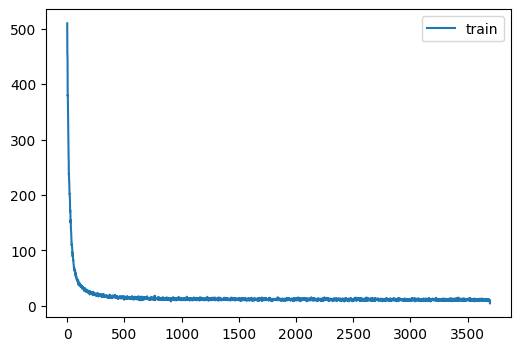

In [23]:
# initialize the convolutional layers in the head with kaiming normal initialization
for m in head_reg4.modules():
    if isinstance(m,(nn.Conv1d,nn.Conv2d,nn.Conv3d)): nn.init.kaiming_normal_(m.weight)

if not INFERENCE_ONLY:
    cbs = [DeviceCB(),ProgressSaveCB(plot=True),TrainCB(),MetricsCB()]
    learn = Learner(model,dls,ssd_loss,lr=1e-4,cbs=cbs,opt_func=optim.AdamW) # 1e-4
    
    freeze(body,True)
    learn.fit(1) # train for 1 epoch just to demonstrate that the model is working

    #Uncomment the following lines to train for a total of 50 epochs if you dare...
    #This took me over a day of training on a single GPU
    #learn.fit(7)
    #freeze(body,False)
    #learn.fit(42)


In [24]:
# You can use the following two lines to save and load your model as necessary
#torch.save(model.state_dict(), 'mycheckpoint.pth')
#model.load_state_dict(torch.load('mycheckpoint.pth'))

### Inference Using the Pretrained Model
Here I show you how to download my pretrained model and use the model for inference.

In [25]:
# Download my pretrained model from Google Drive
!gdown "https://drive.google.com/uc?id=1Gdrz71zKOiprwW3va7PkpdQZhZkTdzDu"

Downloading...
From: https://drive.google.com/uc?id=1Gdrz71zKOiprwW3va7PkpdQZhZkTdzDu
To: /home/jr/code/ObjectDetectionNotebooks/nbs/ssd_resnet34_multi_best.pth
100%|████████████████████████████████████████| 238M/238M [00:02<00:00, 83.0MB/s]


In [26]:
# Load the pretrained model and put the model into evaluation mode
model.load_state_dict(torch.load('ssd_resnet34_multi_best.pth'))
_ = model.eval()

In [27]:
# take a set of bounding boxes and filter out boxes that are redundant because they overlap
# too much using the non-maximum suppression algorithm
# https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c
def nms(pred_bbox,pred_clas,conf_thresh=0.15,area_thresh=0.1,ax=None):
    idx = 0
    a_ic = actn_to_bb(pred_bbox[idx], anchors)
    clas_pr, clas_ids = pred_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    m = clas_ids != 0 # remove the background class
    mix = m.nonzero().squeeze(1)

    clas_ids = clas_ids[mix]
    clas_pr = clas_pr[mix]
    a_ic = a_ic[mix]

    m = clas_pr > conf_thresh # remove low confidence predictions
    mix = m.nonzero().squeeze(1)

    clas_ids = clas_ids[mix]
    clas_pr = clas_pr[mix]
    a_ic = a_ic[mix]

    m = a_ic[:,2:].prod(1) > area_thresh # remove predictions with very small area
    mix = m.nonzero().squeeze(1)

    clas_ids = clas_ids[mix]
    clas_pr = clas_pr[mix]
    a_ic = a_ic[mix]

    clas_pr_sorted = clas_pr.sort(0,descending=True)
    cls_ids_sorted = clas_ids[clas_pr_sorted[1]]
    a_ic_sorted = a_ic[clas_pr_sorted[1]]
    clas_pr_sorted = clas_pr_sorted[0]

    keep_indexes = []
    for c in cls_ids_sorted.unique().tolist():

        m = cls_ids_sorted == c
        clas_indexes = m.nonzero().flatten().tolist()

        while(len(clas_indexes)>0):
            kept_index = clas_indexes[0]
            keep_indexes.append(clas_indexes[0])
            clas_indexes = clas_indexes[1:]

            if(len(clas_indexes) == 0): break
            kept_boxes = a_ic_sorted[kept_index].unsqueeze(0)

            ious = iou(a_ic_sorted[clas_indexes], kept_boxes).flatten()

            m2 = (ious < 0.20)
            clas_indexes = tensor(clas_indexes).to(device)[m2].tolist() # remove all indexes with iou > 0.5


    clas_pr_keep = clas_pr_sorted[keep_indexes]
    clas_ids_keep = cls_ids_sorted[keep_indexes]
    a_ic_keep = a_ic_sorted[keep_indexes]

    return clas_pr_keep, clas_ids_keep, a_ic_keep

# detect objects in an image and return the annotated image
def detectobjects(im,conf_threshold=0.22):
    annotated_im = np.copy(im)

    # perform inference
    im = cv2.resize(im, (SIZE,SIZE))
    im = tfms.ToTensor()(im)
    im = normalize(im)
    im = im.unsqueeze(0)
    pred_cl,pred_bx = model(im.to(device))

    # composite annotations onto image
    h,w = annotated_im.shape[:2]
    prob,clas,box = nms(pred_bx,pred_cl,conf_thresh=conf_threshold)
    for i in range(len(clas)):
        #print(clas[i], prob[i])
        category=id2cat[clas[i].item()]
        pr = prob[i]
        color = colors[clas[i]]
        #print(box[i])

        x1,y1,x2,y2 = box[i].tolist()
        x1 = int(x1*w)
        x2 = int(x2*w)
        y1 = int(y1*h)
        y2 = int(y2*h)
        #print(x1)
        cv2.rectangle(annotated_im,(x1,y1),(x2,y2),color,2)

        text_size = cv2.getTextSize(category + " : %.2f" % pr, cv2.FONT_HERSHEY_PLAIN, 1.5, 1)[0]
        cv2.rectangle(annotated_im, (x1, y1), (x1 + text_size[0] + 3, y1 + text_size[1] + 4), color,
                        -1)
        cv2.putText(annotated_im, category + " : %.2f" % pr,
            (x1, y1 + text_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1.5,
            (255, 255, 255), 1)   
    return annotated_im

## Demonstrate Running Inference on Images from the Validation Set

Now that we've downloaded and loaded the pretrained model. Let's run a batch of data from the validation dataset through our model. In the left column we'll show the images along with their ground truth bounding boxes and class labels.  In the right column, we'll show the predictions from the model.

Text(0.5, 1.0, 'Model Predictions')

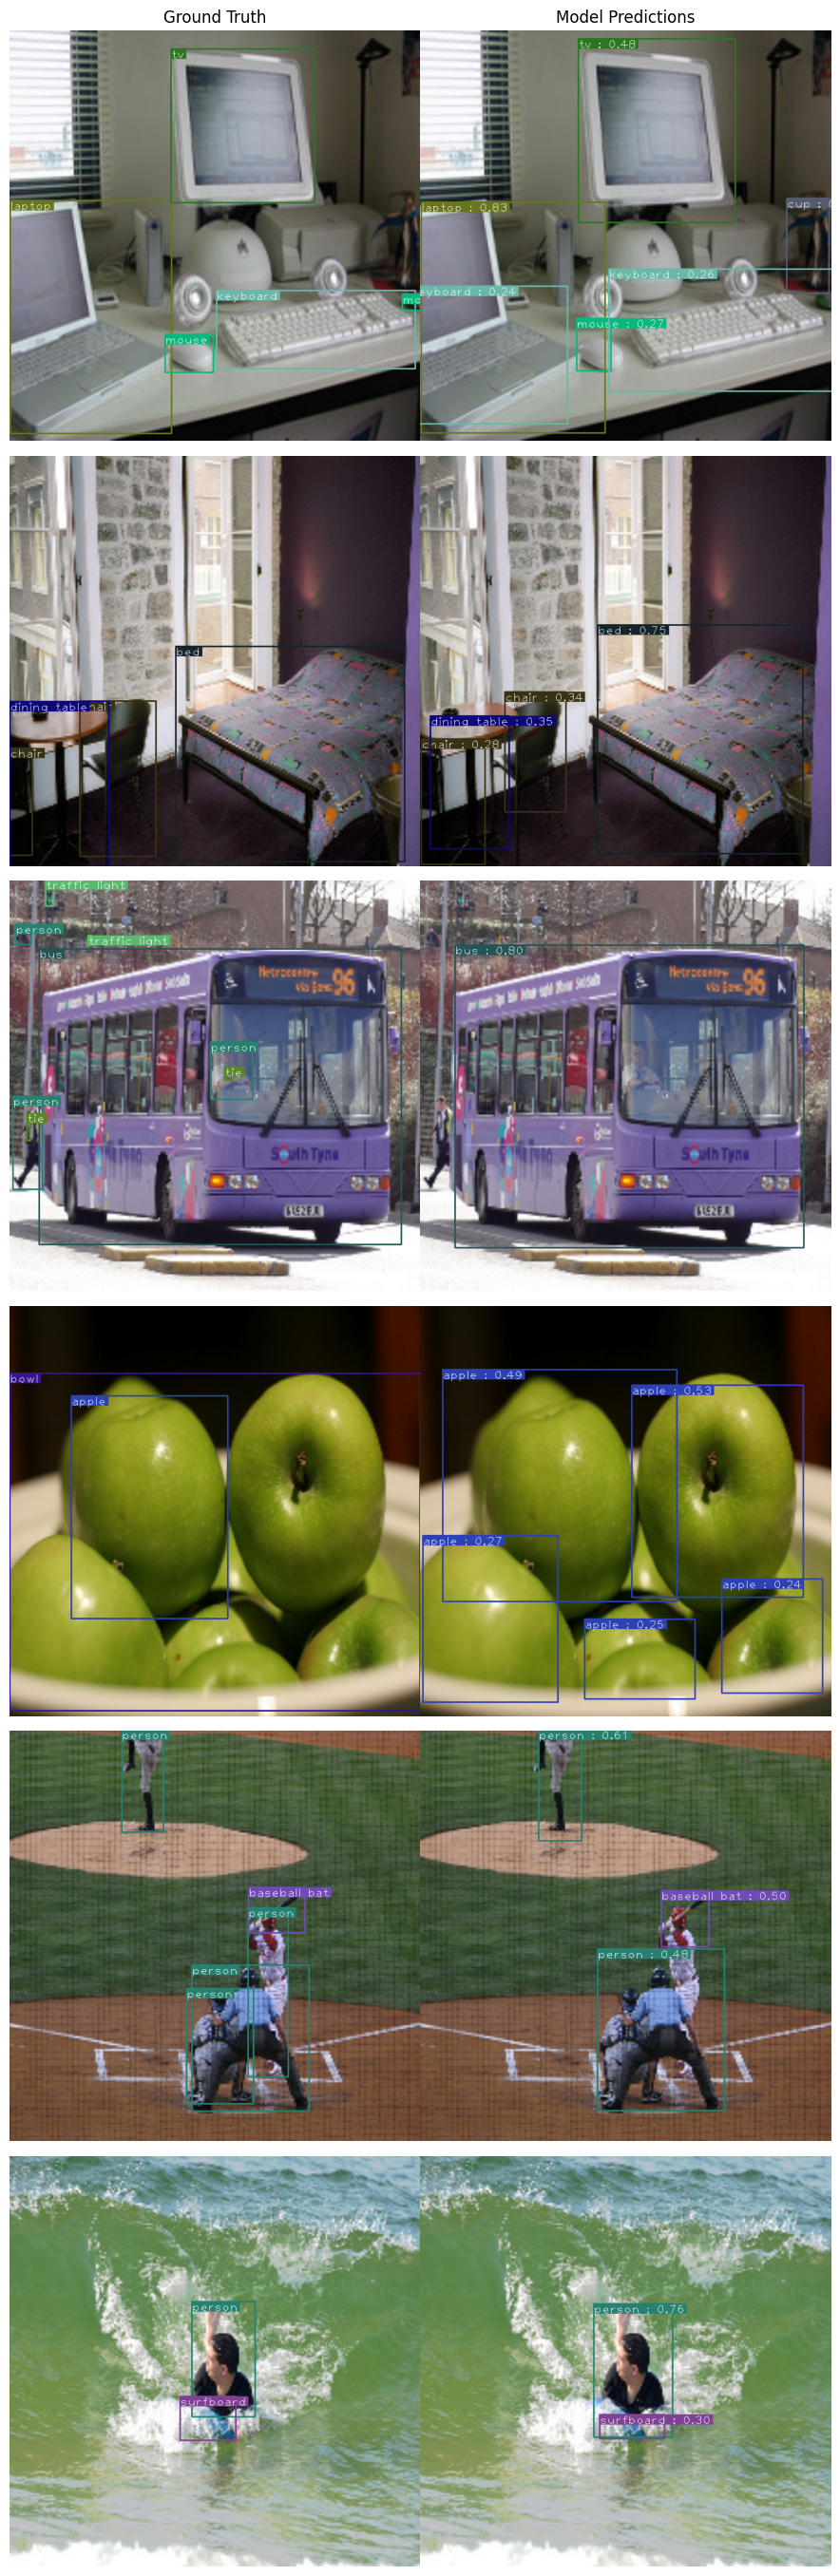

In [28]:
# grab a batch of images from the validation set
xb,targ_bboxb,targ_clasb = next(iter(valid_loader))

# show the ground truth and model predictions
fig, ax = plt.subplots(6,2,figsize=(9,27))
for i,j in enumerate([15,21,22,23,24,26]):
    show_image(showobjects(denormalize_tensor(xb[j]),targ_bboxb[j],targ_clasb[j]),ax=ax[i,0])
    show_image(detectobjects(denormalize_tensor(xb[j])),ax=ax[i,1])
fig.tight_layout()
ax[0,0].set_title('Ground Truth')
ax[0,1].set_title('Model Predictions')

## Demonstrate Running Inference on an Image
Here we download a sample image from the Internet and run inference on it using our trained model.

_Note: Since the bounding box coordinates are normalized to the range 0 to 1 we can scale the bounding box coordinates by the image size so that we can overlay them on top of the orginal image rather than the scaled down image (224x224) that we use for inference._

Give it a try with your own images.

In [29]:
# not sure why but I needed this to work around a colab error
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [30]:
# Image credit: https://www.pexels.com/photo/woman-walking-with-child-on-pathway-2505132/
!curl "https://images.pexels.com/photos/2505132/pexels-photo-2505132.jpeg?cs=srgb&dl=pexels-rene-asmussen-2505132.jpg&fm=jpg&w=640&h=960" > test.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  160k  100  160k    0     0   696k      0 --:--:-- --:--:-- --:--:--  699k


<Axes: >

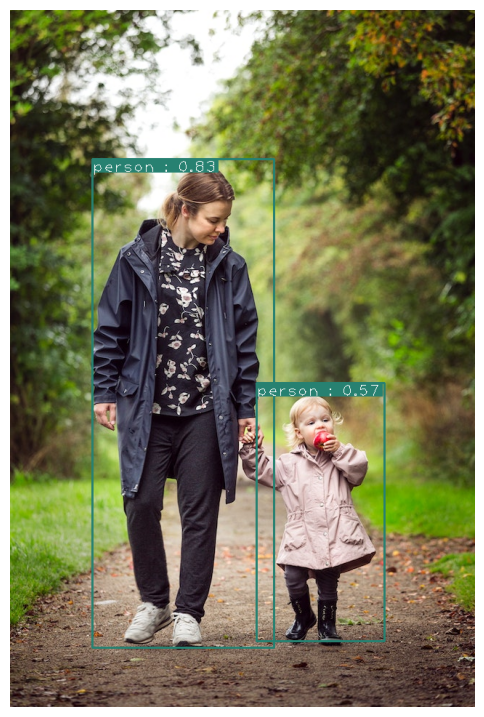

In [31]:
im = np.array(Image.open('./test.jpg'))
show_image(detectobjects(im),figsize=(6,12))

## Demonstrate Runnng Inference on a video

This will reproduce the video shown at the top of the article.  

_Note: I was using pytube to download the video directly from YouTube but as I was wrapping up the article pytube stopped working due to a Youtube change.  So we'll just download it from a copy that I made on my Google Drive._

In [32]:
# Download the sample video
# Video credit: https://www.youtube.com/watch?v=--rAA0lXNfQ
!gdown "https://drive.google.com/uc?id=1jGuEqJpNYb_5we0-gies8hmG6Cds0gWV"

Downloading...
From: https://drive.google.com/uc?id=1jGuEqJpNYb_5we0-gies8hmG6Cds0gWV
To: /home/jr/code/ObjectDetectionNotebooks/nbs/RRR_tutorial.mp4
100%|██████████████████████████████████████| 37.6M/37.6M [00:00<00:00, 48.5MB/s]


In [33]:
# We limit processing to the first minute of the video
# should take < 1 minute
f = 'RRR_tutorial.mp4'

cap = cv2.VideoCapture(f)
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = cap.get(cv2.CAP_PROP_FPS)

stop = int(fps*60) # 1 minute of video
print(f"Stopping after {stop} frames.")

#vid_cod = cv2.VideoWriter_fourcc(*'H264')
vid_cod = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter('./ssd_video_mp4v.mp4', vid_cod, int(cap.get(cv2.CAP_PROP_FPS)),(w, h))

cur_frame = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
        
    cur_frame = cur_frame+1
    if cur_frame > stop: break #capture first minute

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    annotated_im = detectobjects(frame)
    annotated_im = cv2.cvtColor(annotated_im, cv2.COLOR_RGB2BGR)
    out.write(annotated_im)

cap.release()
out.release()

Stopping after 1438 frames.


My installed version of OpenCV didn't have the h264 encoder compiled in so I generated the video with a different codec and I used ffmpeg to reencode it using the h264 codec here (So that the browser is able to decode the video).

In [34]:
# should take about 20 seconds
!ffmpeg -y -i ./ssd_video_mp4v.mp4 -vcodec libx264 -f mp4 ./ssd_video.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [35]:
# This doesn't seem to load the video in colab for some reason
# but you can download the ssd_video.mp4 file and play it locally
HTML("<video src='./ssd_video.mp4' autoplay loop width=800 controls></video>")

### Summary

This has been a challenging project and it took a lot more time to get it working than I had originally anticipated.  But I think the results are pretty good.  I'm sure that there are many ways to improve the results.  I'd love to hear more about any experiments or improvements that you make.

Dealing with anchor boxes makes the code for this model fairly complicated.  There is no single right answers to the questions of how many anchor boxes?  how do you position and layout the anchor boxes? etc.  For future experiments, I think I'd probably turn my attention to anchor box free methods which currently don't perform as well but have the potential to be much simpler and straightforward in implementation.

I'm fairly happy with the results, but the model does seem to struggle with small objects.  If you wanted to try and improve what was done here, Here are a few ideas that I think might be worth exploring:

* More analysis on optimizing the number and layout of the anchor boxes.
* Try a different backbone model.  I think that a resnet50 backbone might work better.  But more compute would be needed to train it.
* More data engineering.  Spend more effort on cleaning the data and analyze whtere the model is still struggling with certain classes of objects.
* Other image augmentation techniques.  I only used a few simple techniques.  There are many more that could be used.  One suggestion: Mixup

If you'd like to see some articles on anchor free methods or on image segmentation, please like my content on twitter and reply to my tweet with topics that you'd like to see me explore.

If you're enjoying this series, please like and retweet my content on Twitter, [@johnrobinsn](https://twitter.com/johnrobinsn)